In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Introduction
In this Notebook we show how to build a multiclass classifier, by:
 - applying simple pre-processing steps
 - trying different baseline algorithms
 - optimizing the hyperparameters of XGBoost
 
In the pre-processing steps, we convert the non numerical features using the LabelEncoding for most of the columns, i.e.for
the columns that have only two possible values or more than two sortable values. The only column that has not these characteristic is the MTRANS, where we apply the one-hot encoding.

Then we do some data exploration, analyzing the correlation between numerical features and labels, the distribution of train and test data, the distribution of labels, etc...

Then we train 4 different baseline classifier: RandomForest, GradientBoosting, LightGBM and XGBoost, XGBoost shows the best performance, so we decide to optimize
its hyperparameters by using the framework Optuna.

Finally we perfrom the predictions in two ways:

 - using all the training data.
 - using 5-fold stratified splitting and computing the average predicted probabilities out of 5


## 1. import data
We import the data and we create two subsets:
 - one with numerical data
 - one with categorical data

In [5]:
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col = 0)
df.head()
df["BMI"] = df["Weight"]/(df["Height"]*df["Height"])
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
id,,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841


['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


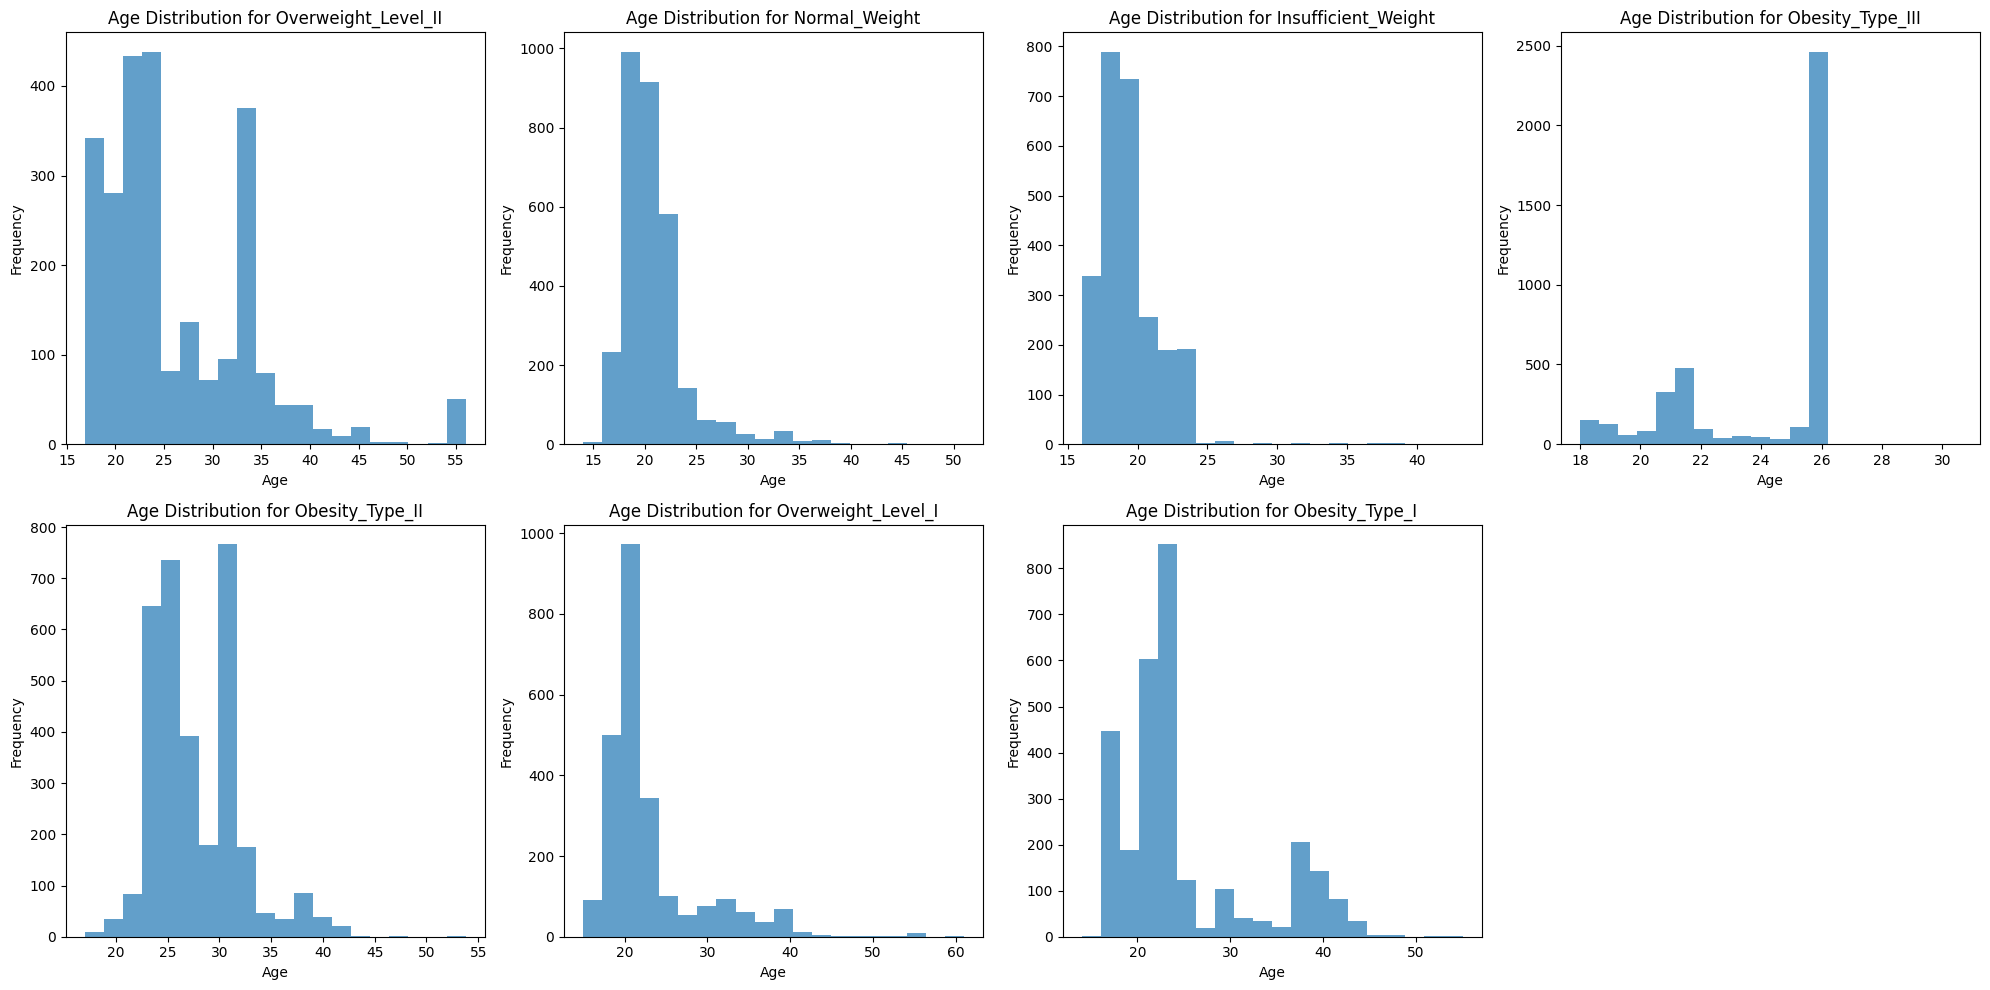

In [6]:
# 각 비만도 별로 나이 분포대 시각화
unique_categories = df['NObeyesdad'].unique()
print(unique_categories)
plt.figure(figsize=(20,10))

for i, category in enumerate(unique_categories, start=1):
    category_data = df[df['NObeyesdad'] == category]['Age']
    plt.subplot(2, 4, i)
    plt.hist(category_data, bins=20, alpha=0.7)
    plt.title(f'Age Distribution for {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    

plt.tight_layout()    
plt.show()

# train_data 결측치 없음을 확인.
df.isnull().sum()

In particular we can deduct that:

- 'Gender', 'Age', 'Height', 'Weight' are physical attributes
- 'family_history_with_overweight' points out to familiarity with obesity
- FAVC = Frequent consumption of high caloric food
- FCVC = Frequency of consumption of vegetables
- NCP = Number of main meals
- CAEC = Consumption of food between meals
- SMOKE = tobacco usage
- CH20 = Consumption of water daily
- SCC = Calories consumption monitoring
- FAF = Physical activity frequency
- TUE = Time using technology devices
-CALC = Consumption of alcohol
MTRANS = Transportation used

In [7]:
# train 데이터 X(features) 독립변수, y(labels) 종속변수 분리
labels = pd.DataFrame(df['NObeyesdad'])
features = df.drop('NObeyesdad', axis=1)

## 2.Data exploration and pre-processing

### Numerical DataFrame

In [8]:
# 독립 변수 중 숫자형 칼럼 분리. df_numerical은 정규화 하기 전의 숫자형 칼럼.
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
id,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,28.259565
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,23.422091
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,17.126706
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,44.855798
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,25.599151
...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,36.587084
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,17.099278
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,31.889841


In [9]:
## 정규화 전 숫자형 칼럼의 평균과 분산
print('feature들의 평균 값')
print(df_numerical.mean())
print('\nfeature들의 분산 값')
print(df_numerical.var())

feature들의 평균 값
Age       23.841804
Height     1.700245
Weight    87.887768
FCVC       2.445908
NCP        2.761332
CH2O       2.029418
FAF        0.981747
TUE        0.616756
BMI       30.241842
dtype: float64

feature들의 분산 값
Age        32.354163
Height      0.007623
Weight    695.875017
FCVC        0.284322
NCP         0.497553
CH2O        0.370232
FAF         0.702750
TUE         0.362541
BMI        69.454421
dtype: float64


In [10]:
# 스케일 시작 -> StandardScaler 사용 -> TEST 1. 정규화 하고 안하고의 정확도 차이. 2. Standard vs min_max
from sklearn.preprocessing import StandardScaler


#객체 생성
scaler = StandardScaler()
scaler.fit(df_numerical)

numerical_scaled = scaler.transform(df_numerical)
df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

print('feature들의 평균 값')
print(df_numerical_scaled.mean())
print('\nfeature들의 분산 값')
print(df_numerical_scaled.var())


feature들의 평균 값
Age       1.889486e-16
Height   -1.107677e-15
Weight   -1.297310e-16
FCVC      1.095354e-16
NCP       1.762836e-17
CH2O     -2.931785e-16
FAF       3.902200e-17
TUE       1.328117e-16
BMI       1.937408e-16
dtype: float64

feature들의 분산 값
Age       1.000048
Height    1.000048
Weight    1.000048
FCVC      1.000048
NCP       1.000048
CH2O      1.000048
FAF       1.000048
TUE       1.000048
BMI       1.000048
dtype: float64


In [11]:
# 이상치 파악 -> 이상치가 있긴 하지만 의미 있는 이상치이기에 제거하지 않음
import pandas as pd

# 각 숫자형 변수의 이상치 개수 계산
outliers = pd.DataFrame(index=df_numerical.columns, columns=["Has Outliers", "Outlier Count"])

for column in df_numerical.columns:
    Q1 = df_numerical[column].quantile(0.25)
    Q3 = df_numerical[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_count = ((df_numerical[column] < lower_bound) | (df_numerical[column] > upper_bound)).sum()
    
    outliers.loc[column, "Has Outliers"] = outlier_count > 0
    outliers.loc[column, "Outlier Count"] = outlier_count

print(outliers)


       Has Outliers Outlier Count
Age            True          1074
Height         True             4
Weight        False             0
FCVC          False             0
NCP            True          6052
CH2O          False             0
FAF           False             0
TUE           False             0
BMI           False             0


### Categorical DataFrame

In [12]:
# 범주형 칼럼만 추출하여 각 컬럼마다 원소 개수 확인
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())


Gender
Female    10422
Male      10336
Name: count, dtype: int64
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64
FAVC
yes    18982
no      1776
Name: count, dtype: int64
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64
SMOKE
no     20513
yes      245
Name: count, dtype: int64
SCC
no     20071
yes      687
Name: count, dtype: int64
CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64
MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


## Encoding

In [13]:
# 범주형 칼럼 인코딩(Label encoding, one-hot encoding)

df_encoded = df_categorical.copy(deep=True)

# Label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_encoded['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes': 1, 'Frequently':2, 'Always':3})
df_encoded['MTRANS'] = df_categorical['MTRANS'].map({'Automobile':0, 'Bike':1, 'Motorbike':2, 'Public_Transportation':3, 'Walking':4})


# concatenate
# one feature of df_encoded is redundant; we can remove it
df_encoded # 문자 -> 숫자 인코딩

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
id,,,,,,,,
0,0,1,1,1,0,0,1,3
1,1,1,1,2,0,0,0,0
2,1,1,1,1,0,0,0,3
3,1,1,1,1,0,0,1,3
4,0,1,1,1,0,0,1,3
...,...,...,...,...,...,...,...,...
20753,0,1,1,1,0,0,1,3
20754,0,0,1,2,0,0,1,3
20755,0,1,1,1,0,0,0,3


### Concatenate all features together

In [14]:
# df_all_features는 스케일과 인코딩이 최종적으로 모두 끝난 독립변수 dataframe
df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

df_all_features

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.237862,0,1,1,1,0,0,1,3
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,-0.818331,1,1,1,2,0,0,0,0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-1.573741,1,1,1,1,0,0,0,3
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1.753591,1,1,1,1,0,0,1,3
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.557096,0,1,1,1,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0.761393,0,1,1,1,0,0,1,3
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,-1.577032,0,0,1,2,0,0,1,3
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0.197750,0,1,1,1,0,0,0,3
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.161050,0,1,1,1,0,0,0,0


### Define a pre_processing pipeline
Let us summarize all the previous steps into a function, called 'apply_preprocessing'

In [15]:
# 위 전처리 코드를 파이프라인 함수 코드로 만듦 -> test 데이터의 독립변수 전처리할 때 사용할 예정
def apply_preprocessing(data):
    features = data.copy(deep=True)
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]
    
    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]
    #객체 생성

    numerical_scaled = scaler.transform(df_numerical)
    df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['MTRANS'] = df_categorical['MTRANS'].map({'Automobile':0, 'Bike':1, 'Motorbike':2, 'Public_Transportation':3, 'Walking':4})
    
    # one feature of df_encoded is redundant; we can remove it
    df_numerical_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)
    # concatenate
    # one feature of df_encoded is redundant; we can remove it
    df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

    
    return df_all_features


### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.
The test dataset will be used to make predictions and submit them to the competition.

In [16]:
# test 데이터를 불러옴. test 데이터 파일 전체가 종속 변수가 됨.
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col = 0)
df_test["BMI"] = df_test["Weight"]/(df_test["Height"]*df_test["Height"])
# 불러온 test를 위에서 만들어놓은 전처리 pipeline 함수 'apply_preprocessing'을 이용하여 인코딩과 스케일 적용
df_test = apply_preprocessing(df_test)

print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)
print(df_test.head())
assert all(df_test.columns == df_all_features.columns), "Column in train and test dataset must be the same"

Train columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')
Test columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')
        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0  0.537644  1.695675  1.241770  0.924049  0.338364  1.308584 -0.150721   
1 -0.499620 -1.148152 -0.829748 -0.836279 -2.497077  1.595165  0.021775   
2  0.379434 -0.651587  0.898933  1.039171  0.338364  0.973714 -1.171141   
3 -0.503267 -1.685011  0.598259 -0.836279  0.307045  1.244138 -1.057992   
4  0.379434 -0.834373  0.642469  1.039171  0.338364  1.025738 -1.171141   

        TUE       BMI  Gender  family_history_with_overweight  FAVC  CAEC  \
0 -1.024344  0.608799      

### Labels

In [17]:
# labels는 train데이터의 종속 변수
labels['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [18]:
# labels의 값을 인코딩 함
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded.value_counts()


NObeyesdad
6             4046
5             3248
1             3082
4             2910
0             2523
3             2522
2             2427
Name: count, dtype: int64

## 3.Prepare data for machine learning

In [19]:
from sklearn.model_selection import train_test_split


# X는 train 데이터의 독립변수 y는 train 데이터의 종속변수
X = df_all_features.loc[: , ["Height", "Weight", "FCVC", "CH2O", "NCP", "FAF", "TUE", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]]
# 머신러닝 모델을 훈련할 때는 대부분의 경우 np.ravel()을 사용하여 타겟 변수를 1차원 배열로 변환하는 것이 안전함.
y = np.ravel(labels_encoded)

# compare train and test data
# X_test는 test 데이터의 독립변수
X_test = df_test.loc[: , [ "Height", "Weight", "FCVC", "CH2O", "NCP", "FAF", "TUE", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC","MTRANS"]]
assert all(X_test.columns == X.columns), "Columns of trainging and test data must be the same"

print('Number of samples', len(X))
print('Number of featires', X.shape[1])

# train 데이터를 나눠주어 검증 데이터를 만들어 줌.
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Number of samples 20758
Number of featires 15


## Fit the data with baseline models

In [20]:
# 일단은 4개의 모델을 기본값으로 사용하여 정확도를 측정해본다!
# 그래디언트 부스트, 랜덤, LGBM, XGB 사용
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 15
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
# X_train과 X_validation을 사용하여 정확도를 평가하는 함수.
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)
    
    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
    
    print('=========================================')

In [22]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 0.999
Test score 0.89
Overfitting detected
LightGBM
Train score 0.973
Test score 0.9
Overfitting detected
Gradient Boosting
Train score 0.918
Test score 0.895
XGBoost
Train score 0.979
Test score 0.896
Overfitting detected


## 5. Hyperparameter tuning
We fine_tune the XGBoost Classifier, LightGBM defined in the previous section, using the optimizer framework called Optuna

In [23]:
# 하이퍼파라미터 튜닝(여기서 XGBoost와 LightGBM 파라미터 튜닝을 한 번에 함 -> 시간 오래 걸림)
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    # XGBoost 
    if trial.suggest_categorical('model', ['xgboost', 'lightgbm']) == 'xgboost':
        params = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'gamma': gamma,
                  'reg_alpha': reg_alpha,
                  'reg_lambda': reg_lambda,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'eval_metric':'mlogloss'}

        clf = XGBClassifier(**params)
   
    # LightGBM
    else:
        params = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'lambda_l1': reg_alpha,
                  'lambda_l2': reg_lambda,
                  'colsample_bytree': colsample_bytree, 
                  'subsample': subsample,    
                  'min_child_samples': min_child_weight,
                  'class_weight': 'balanced'}

        clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)
    
    # 교차검증까지 함.
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [24]:
# Uncomment this section if you want to do hyperparameter tuning
# 하이퍼파라미터 튜닝 시작 코드
# n_trials가 반복 횟수
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

[I 2024-02-29 11:10:43,436] A new study created in memory with name: no-name-e3d102b5-0045-437d-a245-95e3b98ead4d


Training the model with 15 features


[I 2024-02-29 11:11:16,422] Trial 0 finished with value: 0.8847193076023652 and parameters: {'max_depth': 5, 'n_estimators': 800, 'gamma': 0.6654855924136466, 'reg_alpha': 0.6867745019145484, 'reg_lambda': 0.8715116731541533, 'min_child_weight': 9, 'subsample': 0.2790405133132643, 'colsample_bytree': 0.8536575602849006, 'learning_rate': 0.6292850129688413, 'model': 'xgboost'}. Best is trial 0 with value: 0.8847193076023652.


Training the model with 15 features


[I 2024-02-29 11:11:56,962] Trial 1 finished with value: 0.8977262947990804 and parameters: {'max_depth': 5, 'n_estimators': 1288, 'gamma': 0.42660837640968075, 'reg_alpha': 0.728295629287088, 'reg_lambda': 0.6783608966277734, 'min_child_weight': 7, 'subsample': 0.5782326511261865, 'colsample_bytree': 0.3063827676957752, 'learning_rate': 0.3986735518473482, 'model': 'xgboost'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:12:45,379] Trial 2 finished with value: 0.8917044851647976 and parameters: {'max_depth': 10, 'n_estimators': 1756, 'gamma': 0.5631101970636442, 'reg_alpha': 0.47418531325423485, 'reg_lambda': 0.23664681488729533, 'min_child_weight': 2, 'subsample': 0.929971559780917, 'colsample_bytree': 0.09796958101531805, 'learning_rate': 0.16267509585833018, 'model': 'xgboost'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:13:19,822] Trial 3 finished with value: 0.882985017886908 and parameters: {'max_depth': 7, 'n_estimators': 981, 'gamma': 0.07492185549401076, 'reg_alpha': 0.5592496811694398, 'reg_lambda': 0.3814469026213255, 'min_child_weight': 3, 'subsample': 0.510086899995175, 'colsample_bytree': 0.045653576109408345, 'learning_rate': 0.5859061347736209, 'model': 'xgboost'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:14:03,620] Trial 4 finished with value: 0.893101506752093 and parameters: {'max_depth': 4, 'n_estimators': 1829, 'gamma': 0.810014309377997, 'reg_alpha': 0.41042622348978697, 'reg_lambda': 0.4301631857433499, 'min_child_weight': 9, 'subsample': 0.9315786244079737, 'colsample_bytree': 0.005708801211784853, 'learning_rate': 0.6756270074401618, 'model': 'xgboost'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:14:36,306] Trial 5 finished with value: 0.8855382016729724 and parameters: {'max_depth': 10, 'n_estimators': 1269, 'gamma': 0.5903055989158393, 'reg_alpha': 0.43735945829665235, 'reg_lambda': 0.6184245888656789, 'min_child_weight': 9, 'subsample': 0.41488709196665585, 'colsample_bytree': 0.506210470869581, 'learning_rate': 0.7828945150449945, 'model': 'lightgbm'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:15:23,121] Trial 6 finished with value: 0.8857791538961062 and parameters: {'max_depth': 10, 'n_estimators': 1433, 'gamma': 0.1502788161817057, 'reg_alpha': 0.3904265588156032, 'reg_lambda': 0.06718762314425408, 'min_child_weight': 1, 'subsample': 0.9025907132042453, 'colsample_bytree': 0.08152311321888683, 'learning_rate': 0.13401317064217755, 'model': 'xgboost'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:15:43,239] Trial 7 finished with value: 0.8684845655502841 and parameters: {'max_depth': 5, 'n_estimators': 653, 'gamma': 0.20778325012882792, 'reg_alpha': 0.4489230963572012, 'reg_lambda': 0.29527042643766366, 'min_child_weight': 1, 'subsample': 0.10803004661584725, 'colsample_bytree': 0.09240983527747715, 'learning_rate': 0.8382808356728816, 'model': 'xgboost'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:16:10,883] Trial 8 finished with value: 0.8849602946384765 and parameters: {'max_depth': 8, 'n_estimators': 862, 'gamma': 0.757497019521602, 'reg_alpha': 0.117015320367862, 'reg_lambda': 0.5865025115725729, 'min_child_weight': 3, 'subsample': 0.6430438231583596, 'colsample_bytree': 0.6950842730197941, 'learning_rate': 0.8190557973718422, 'model': 'lightgbm'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:17:14,314] Trial 9 finished with value: 0.8875135016331928 and parameters: {'max_depth': 10, 'n_estimators': 1999, 'gamma': 0.6385571816919621, 'reg_alpha': 0.26403861772689174, 'reg_lambda': 0.9309207178807466, 'min_child_weight': 0, 'subsample': 0.5177138878011392, 'colsample_bytree': 0.9778268121599825, 'learning_rate': 0.9427034007439004, 'model': 'xgboost'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:17:57,302] Trial 10 finished with value: 0.897341147222226 and parameters: {'max_depth': 7, 'n_estimators': 1488, 'gamma': 0.3500237904233974, 'reg_alpha': 0.9464292104985657, 'reg_lambda': 0.7610700725767628, 'min_child_weight': 6, 'subsample': 0.7358015323332893, 'colsample_bytree': 0.36821757744853856, 'learning_rate': 0.3411072480854821, 'model': 'lightgbm'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:18:41,336] Trial 11 finished with value: 0.8963294472766735 and parameters: {'max_depth': 7, 'n_estimators': 1489, 'gamma': 0.3516085816456791, 'reg_alpha': 0.9839470913342944, 'reg_lambda': 0.7238608136822544, 'min_child_weight': 6, 'subsample': 0.7135587258183553, 'colsample_bytree': 0.31438121255614465, 'learning_rate': 0.36650401368717667, 'model': 'lightgbm'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:19:18,079] Trial 12 finished with value: 0.8964739211342161 and parameters: {'max_depth': 6, 'n_estimators': 1145, 'gamma': 0.37639274064870015, 'reg_alpha': 0.9159114314095799, 'reg_lambda': 0.7389086450369553, 'min_child_weight': 6, 'subsample': 0.7293449109924541, 'colsample_bytree': 0.31437229485099577, 'learning_rate': 0.3799333679875676, 'model': 'lightgbm'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:20:05,894] Trial 13 finished with value: 0.895943951570042 and parameters: {'max_depth': 8, 'n_estimators': 1552, 'gamma': 0.9828971498761016, 'reg_alpha': 0.7871153902315324, 'reg_lambda': 0.7799112678859976, 'min_child_weight': 7, 'subsample': 0.7551169752279956, 'colsample_bytree': 0.345019486313457, 'learning_rate': 0.36202091449832535, 'model': 'lightgbm'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:20:53,449] Trial 14 finished with value: 0.8967146760838093 and parameters: {'max_depth': 4, 'n_estimators': 1263, 'gamma': 0.36698907349551835, 'reg_alpha': 0.7940821172662504, 'reg_lambda': 0.990840923614666, 'min_child_weight': 7, 'subsample': 0.3293327936227721, 'colsample_bytree': 0.4799382928008986, 'learning_rate': 0.24647092511479363, 'model': 'lightgbm'}. Best is trial 1 with value: 0.8977262947990804.


Training the model with 15 features


[I 2024-02-29 11:22:53,008] Trial 15 finished with value: 0.9009056480110882 and parameters: {'max_depth': 6, 'n_estimators': 1677, 'gamma': 0.42689470080503683, 'reg_alpha': 0.6616797569812809, 'reg_lambda': 0.5678268372485871, 'min_child_weight': 4, 'subsample': 0.606954630850891, 'colsample_bytree': 0.492334263795119, 'learning_rate': 0.02260884352058745, 'model': 'lightgbm'}. Best is trial 15 with value: 0.9009056480110882.


Training the model with 15 features


[I 2024-02-29 11:24:12,473] Trial 16 finished with value: 0.9043742970679582 and parameters: {'max_depth': 5, 'n_estimators': 1712, 'gamma': 0.4551900250047093, 'reg_alpha': 0.6418504682032995, 'reg_lambda': 0.5500197572714239, 'min_child_weight': 4, 'subsample': 0.59085662427189, 'colsample_bytree': 0.6123975365623181, 'learning_rate': 0.02059865454726606, 'model': 'xgboost'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:26:14,607] Trial 17 finished with value: 0.9026882349309705 and parameters: {'max_depth': 6, 'n_estimators': 1710, 'gamma': 0.22630037729828123, 'reg_alpha': 0.6148087351991397, 'reg_lambda': 0.5101665445929061, 'min_child_weight': 4, 'subsample': 0.18734281913565487, 'colsample_bytree': 0.6557573151456828, 'learning_rate': 0.01370896561068846, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:28:37,056] Trial 18 finished with value: 0.9028809711799605 and parameters: {'max_depth': 6, 'n_estimators': 1959, 'gamma': 0.22192354930290237, 'reg_alpha': 0.5825318169558447, 'reg_lambda': 0.4799149236925663, 'min_child_weight': 4, 'subsample': 0.015476748135703627, 'colsample_bytree': 0.6887969053502656, 'learning_rate': 0.009281736307668285, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:29:41,996] Trial 19 finished with value: 0.8822624397213291 and parameters: {'max_depth': 4, 'n_estimators': 1907, 'gamma': 0.03624436239970008, 'reg_alpha': 0.1733438400368974, 'reg_lambda': 0.168615025645509, 'min_child_weight': 4, 'subsample': 0.018429916955936015, 'colsample_bytree': 0.7239134271235219, 'learning_rate': 0.17053887267238904, 'model': 'xgboost'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:31:10,518] Trial 20 finished with value: 0.8942577617854696 and parameters: {'max_depth': 8, 'n_estimators': 1995, 'gamma': 0.26486232670901044, 'reg_alpha': 0.2779729888819751, 'reg_lambda': 0.41134512302689086, 'min_child_weight': 5, 'subsample': 0.3792261503128248, 'colsample_bytree': 0.8076233655899694, 'learning_rate': 0.08864446718049558, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:32:34,165] Trial 21 finished with value: 0.8971482136996958 and parameters: {'max_depth': 6, 'n_estimators': 1666, 'gamma': 0.23585942784828315, 'reg_alpha': 0.5798008225088933, 'reg_lambda': 0.49522951426688633, 'min_child_weight': 4, 'subsample': 0.15144780612314968, 'colsample_bytree': 0.6165546882400386, 'learning_rate': 0.06485488246350388, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:34:39,409] Trial 22 finished with value: 0.8999904032224748 and parameters: {'max_depth': 6, 'n_estimators': 1815, 'gamma': 0.14300874177293432, 'reg_alpha': 0.6051785808512218, 'reg_lambda': 0.5130561257421293, 'min_child_weight': 3, 'subsample': 0.19510471246887923, 'colsample_bytree': 0.6068732564363202, 'learning_rate': 0.02035874054537037, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:35:25,068] Trial 23 finished with value: 0.8974853541802726 and parameters: {'max_depth': 5, 'n_estimators': 1623, 'gamma': 0.5000484540376451, 'reg_alpha': 0.8065162805177688, 'reg_lambda': 0.29290875156342744, 'min_child_weight': 5, 'subsample': 0.012500815949037125, 'colsample_bytree': 0.5964686540790135, 'learning_rate': 0.24075583599234873, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:37:39,611] Trial 24 finished with value: 0.9021585554749441 and parameters: {'max_depth': 6, 'n_estimators': 1881, 'gamma': 0.2969236903003478, 'reg_alpha': 0.5192811242878548, 'reg_lambda': 0.4842390755658322, 'min_child_weight': 2, 'subsample': 0.2587941659097127, 'colsample_bytree': 0.780939340383647, 'learning_rate': 0.002827969101043052, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:38:26,956] Trial 25 finished with value: 0.895221245756878 and parameters: {'max_depth': 7, 'n_estimators': 1741, 'gamma': 0.13428788462073027, 'reg_alpha': 0.6547689702758117, 'reg_lambda': 0.6159833604554463, 'min_child_weight': 4, 'subsample': 0.09369775782216155, 'colsample_bytree': 0.901527535335978, 'learning_rate': 0.24610633425980402, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:39:25,639] Trial 26 finished with value: 0.8956066138159248 and parameters: {'max_depth': 5, 'n_estimators': 1382, 'gamma': 0.4461553504716708, 'reg_alpha': 0.3406942481773548, 'reg_lambda': 0.37525515964873746, 'min_child_weight': 2, 'subsample': 0.4155345952344349, 'colsample_bytree': 0.6720883531538202, 'learning_rate': 0.12195039314989695, 'model': 'xgboost'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:40:01,055] Trial 27 finished with value: 0.8952693572920889 and parameters: {'max_depth': 9, 'n_estimators': 1103, 'gamma': 0.511954409584358, 'reg_alpha': 0.8718684596587546, 'reg_lambda': 0.31925322644847354, 'min_child_weight': 5, 'subsample': 0.22275791134141656, 'colsample_bytree': 0.4129397389825614, 'learning_rate': 0.4660864336883169, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:41:04,650] Trial 28 finished with value: 0.8889108597459394 and parameters: {'max_depth': 6, 'n_estimators': 1593, 'gamma': 0.21537128605631967, 'reg_alpha': 0.0014740120946801216, 'reg_lambda': 0.5308106131411582, 'min_child_weight': 3, 'subsample': 0.08468253417824383, 'colsample_bytree': 0.20178979378638173, 'learning_rate': 0.2002655837517414, 'model': 'xgboost'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:42:41,187] Trial 29 finished with value: 0.8987379367230034 and parameters: {'max_depth': 5, 'n_estimators': 1923, 'gamma': 0.004850018421377722, 'reg_alpha': 0.7035359076776999, 'reg_lambda': 0.8168161271106162, 'min_child_weight': 8, 'subsample': 0.30689045146826077, 'colsample_bytree': 0.87380292112678, 'learning_rate': 0.07549573292053849, 'model': 'xgboost'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:43:31,804] Trial 30 finished with value: 0.8977744991688983 and parameters: {'max_depth': 5, 'n_estimators': 1763, 'gamma': 0.7080732659960061, 'reg_alpha': 0.6147898585484837, 'reg_lambda': 0.46800157703480433, 'min_child_weight': 10, 'subsample': 0.15987255748580703, 'colsample_bytree': 0.5502469731090309, 'learning_rate': 0.27057072575975033, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:45:44,007] Trial 31 finished with value: 0.8971000209342039 and parameters: {'max_depth': 6, 'n_estimators': 1877, 'gamma': 0.3102276474229969, 'reg_alpha': 0.5555185078654875, 'reg_lambda': 0.6726517760939192, 'min_child_weight': 2, 'subsample': 0.2570258153831523, 'colsample_bytree': 0.7955135277764284, 'learning_rate': 0.023144742353541338, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:48:01,185] Trial 32 finished with value: 0.8997978294340477 and parameters: {'max_depth': 6, 'n_estimators': 1894, 'gamma': 0.29633388831425267, 'reg_alpha': 0.5154229061280845, 'reg_lambda': 0.4474536885825313, 'min_child_weight': 1, 'subsample': 0.0016067511220629778, 'colsample_bytree': 0.7551767393749781, 'learning_rate': 0.015564405748079914, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:49:08,262] Trial 33 finished with value: 0.8953175848705583 and parameters: {'max_depth': 7, 'n_estimators': 1776, 'gamma': 0.19349286835765112, 'reg_alpha': 0.5101518276523692, 'reg_lambda': 0.6662226469310681, 'min_child_weight': 4, 'subsample': 0.47182931138706197, 'colsample_bytree': 0.667526407743227, 'learning_rate': 0.11480132520125982, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:49:57,544] Trial 34 finished with value: 0.8964738282996088 and parameters: {'max_depth': 5, 'n_estimators': 1700, 'gamma': 0.4521840758919143, 'reg_alpha': 0.7531596122287956, 'reg_lambda': 0.5551429735629194, 'min_child_weight': 2, 'subsample': 0.24825041264135259, 'colsample_bytree': 0.7990821390570015, 'learning_rate': 0.18291565150977854, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:51:29,523] Trial 35 finished with value: 0.9016767090503066 and parameters: {'max_depth': 4, 'n_estimators': 1956, 'gamma': 0.08644152401726413, 'reg_alpha': 0.6947659900075824, 'reg_lambda': 0.18710991046150444, 'min_child_weight': 3, 'subsample': 0.33822103991117836, 'colsample_bytree': 0.6418390758313608, 'learning_rate': 0.006549232299237202, 'model': 'xgboost'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:52:31,511] Trial 36 finished with value: 0.8897775984522613 and parameters: {'max_depth': 6, 'n_estimators': 1854, 'gamma': 0.27561131964198593, 'reg_alpha': 0.492524501414168, 'reg_lambda': 0.35975973440644005, 'min_child_weight': 0, 'subsample': 0.5466939186034673, 'colsample_bytree': 0.5545926531528471, 'learning_rate': 0.5824102326470014, 'model': 'xgboost'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:53:38,557] Trial 37 finished with value: 0.895654748559787 and parameters: {'max_depth': 7, 'n_estimators': 1369, 'gamma': 0.5722244398959432, 'reg_alpha': 0.6371731318287241, 'reg_lambda': 0.45941830276438606, 'min_child_weight': 5, 'subsample': 0.8211676480693322, 'colsample_bytree': 0.9243642238281026, 'learning_rate': 0.07829319333960935, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:54:46,911] Trial 38 finished with value: 0.876336795135838 and parameters: {'max_depth': 5, 'n_estimators': 1531, 'gamma': 0.10409018830889709, 'reg_alpha': 0.34487701480660515, 'reg_lambda': 0.6407454171845709, 'min_child_weight': 3, 'subsample': 0.06560726401850764, 'colsample_bytree': 0.745607576974222, 'learning_rate': 0.3035694118249211, 'model': 'xgboost'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:55:09,326] Trial 39 finished with value: 0.8941614226717893 and parameters: {'max_depth': 4, 'n_estimators': 601, 'gamma': 0.17668149848918133, 'reg_alpha': 0.5386155655145085, 'reg_lambda': 0.5137397873365097, 'min_child_weight': 1, 'subsample': 0.1580220759564696, 'colsample_bytree': 0.8372777898802541, 'learning_rate': 0.4528363650014352, 'model': 'lightgbm'}. Best is trial 16 with value: 0.9043742970679582.


Training the model with 15 features


[I 2024-02-29 11:55:54,842] Trial 40 finished with value: 0.9043743550895877 and parameters: {'max_depth': 6, 'n_estimators': 1819, 'gamma': 0.530279208305952, 'reg_alpha': 0.4126857700703246, 'reg_lambda': 0.4063774801278828, 'min_child_weight': 6, 'subsample': 0.9927303375195966, 'colsample_bytree': 0.4535476975261293, 'learning_rate': 0.14664159052397566, 'model': 'xgboost'}. Best is trial 40 with value: 0.9043743550895877.


Training the model with 15 features


[I 2024-02-29 11:56:40,905] Trial 41 finished with value: 0.9049040693585919 and parameters: {'max_depth': 6, 'n_estimators': 1794, 'gamma': 0.5330482761192173, 'reg_alpha': 0.4635183475458319, 'reg_lambda': 0.39895486447709677, 'min_child_weight': 6, 'subsample': 0.9852118516850394, 'colsample_bytree': 0.4048905760284056, 'learning_rate': 0.15031970663862534, 'model': 'xgboost'}. Best is trial 41 with value: 0.9049040693585919.


Training the model with 15 features


[I 2024-02-29 11:57:26,756] Trial 42 finished with value: 0.9020620074833976 and parameters: {'max_depth': 5, 'n_estimators': 1772, 'gamma': 0.6124254803140468, 'reg_alpha': 0.3920613553710373, 'reg_lambda': 0.40958490800803526, 'min_child_weight': 6, 'subsample': 0.9846402402915314, 'colsample_bytree': 0.19022682137438585, 'learning_rate': 0.15713985564225666, 'model': 'xgboost'}. Best is trial 41 with value: 0.9049040693585919.


Training the model with 15 features


[I 2024-02-29 11:58:15,781] Trial 43 finished with value: 0.9049523085413874 and parameters: {'max_depth': 7, 'n_estimators': 1626, 'gamma': 0.5536093613679174, 'reg_alpha': 0.4730216639598105, 'reg_lambda': 0.24437052756132965, 'min_child_weight': 8, 'subsample': 0.888128721436173, 'colsample_bytree': 0.4207944447355266, 'learning_rate': 0.06597789719033417, 'model': 'xgboost'}. Best is trial 43 with value: 0.9049523085413874.


Training the model with 15 features


[I 2024-02-29 11:58:57,968] Trial 44 finished with value: 0.9036998768548934 and parameters: {'max_depth': 7, 'n_estimators': 1610, 'gamma': 0.5370277547987775, 'reg_alpha': 0.4582940905773931, 'reg_lambda': 0.24265201493158603, 'min_child_weight': 8, 'subsample': 0.8765506050588233, 'colsample_bytree': 0.4544814086017976, 'learning_rate': 0.20148022487648434, 'model': 'xgboost'}. Best is trial 43 with value: 0.9049523085413874.


Training the model with 15 features


[I 2024-02-29 11:59:42,693] Trial 45 finished with value: 0.903940713034768 and parameters: {'max_depth': 8, 'n_estimators': 1636, 'gamma': 0.546367850536419, 'reg_alpha': 0.4488514944188497, 'reg_lambda': 0.034494522285818285, 'min_child_weight': 8, 'subsample': 0.8602445455964381, 'colsample_bytree': 0.42519628261828946, 'learning_rate': 0.19151986313346364, 'model': 'xgboost'}. Best is trial 43 with value: 0.9049523085413874.


Training the model with 15 features


[I 2024-02-29 12:00:20,720] Trial 46 finished with value: 0.9050006173501384 and parameters: {'max_depth': 8, 'n_estimators': 1472, 'gamma': 0.6794932298331594, 'reg_alpha': 0.4219878210027277, 'reg_lambda': 0.027860748860535953, 'min_child_weight': 8, 'subsample': 0.9918790585552149, 'colsample_bytree': 0.4135643738263233, 'learning_rate': 0.12410624645719219, 'model': 'xgboost'}. Best is trial 46 with value: 0.9050006173501384.


Training the model with 15 features


[I 2024-02-29 12:00:59,473] Trial 47 finished with value: 0.9035552637454402 and parameters: {'max_depth': 9, 'n_estimators': 1460, 'gamma': 0.6831778029940363, 'reg_alpha': 0.3448157144930566, 'reg_lambda': 0.10976627986410592, 'min_child_weight': 9, 'subsample': 0.9976382339696036, 'colsample_bytree': 0.24291535628296015, 'learning_rate': 0.12772536632986248, 'model': 'xgboost'}. Best is trial 46 with value: 0.9050006173501384.


Training the model with 15 features


[I 2024-02-29 12:01:32,608] Trial 48 finished with value: 0.9000868351707624 and parameters: {'max_depth': 8, 'n_estimators': 1340, 'gamma': 0.7677301392801873, 'reg_alpha': 0.26077924937966646, 'reg_lambda': 0.0026784267713846344, 'min_child_weight': 7, 'subsample': 0.9197417847333005, 'colsample_bytree': 0.3901396806566636, 'learning_rate': 0.6684721031992983, 'model': 'xgboost'}. Best is trial 46 with value: 0.9050006173501384.


Training the model with 15 features


[I 2024-02-29 12:02:10,353] Trial 49 finished with value: 0.9034589594447375 and parameters: {'max_depth': 9, 'n_estimators': 1544, 'gamma': 0.8309456961062859, 'reg_alpha': 0.40037191107007164, 'reg_lambda': 0.12119231260685119, 'min_child_weight': 7, 'subsample': 0.9638769343383174, 'colsample_bytree': 0.26766477177294856, 'learning_rate': 0.30554479381763233, 'model': 'xgboost'}. Best is trial 46 with value: 0.9050006173501384.


Training the model with 15 features


[I 2024-02-29 12:02:50,054] Trial 50 finished with value: 0.9043741926290251 and parameters: {'max_depth': 7, 'n_estimators': 1162, 'gamma': 0.6362465596478443, 'reg_alpha': 0.4234514797569822, 'reg_lambda': 0.2484114951954452, 'min_child_weight': 10, 'subsample': 0.7852841174839066, 'colsample_bytree': 0.5436445661642733, 'learning_rate': 0.06894741108210678, 'model': 'xgboost'}. Best is trial 46 with value: 0.9050006173501384.


Training the model with 15 features


[I 2024-02-29 12:03:28,595] Trial 51 finished with value: 0.9051932027428913 and parameters: {'max_depth': 7, 'n_estimators': 1185, 'gamma': 0.6279675498991473, 'reg_alpha': 0.41524381739479155, 'reg_lambda': 0.23161825118065815, 'min_child_weight': 10, 'subsample': 0.8088210308405303, 'colsample_bytree': 0.5365833437698988, 'learning_rate': 0.06751319656864713, 'model': 'xgboost'}. Best is trial 51 with value: 0.9051932027428913.


Training the model with 15 features


[I 2024-02-29 12:04:00,143] Trial 52 finished with value: 0.9045186896952193 and parameters: {'max_depth': 8, 'n_estimators': 879, 'gamma': 0.5977662758668119, 'reg_alpha': 0.2984462072363952, 'reg_lambda': 0.16878264323978256, 'min_child_weight': 9, 'subsample': 0.6636585057574537, 'colsample_bytree': 0.4538385308515942, 'learning_rate': 0.11513501655283676, 'model': 'xgboost'}. Best is trial 51 with value: 0.9051932027428913.


Training the model with 15 features


[I 2024-02-29 12:04:25,061] Trial 53 finished with value: 0.9042779927672557 and parameters: {'max_depth': 8, 'n_estimators': 752, 'gamma': 0.7239131861054328, 'reg_alpha': 0.3025609776711493, 'reg_lambda': 0.18960696171793395, 'min_child_weight': 10, 'subsample': 0.67161957438094, 'colsample_bytree': 0.3467904880300881, 'learning_rate': 0.14395474262484687, 'model': 'xgboost'}. Best is trial 51 with value: 0.9051932027428913.


Training the model with 15 features


[I 2024-02-29 12:04:45,420] Trial 54 finished with value: 0.8942577501811435 and parameters: {'max_depth': 8, 'n_estimators': 850, 'gamma': 0.5944240654577414, 'reg_alpha': 0.22012285355572847, 'reg_lambda': 0.09476447406151933, 'min_child_weight': 9, 'subsample': 0.950323211173133, 'colsample_bytree': 0.44436785308376925, 'learning_rate': 0.974868831756159, 'model': 'xgboost'}. Best is trial 51 with value: 0.9051932027428913.


Training the model with 15 features


[I 2024-02-29 12:05:17,775] Trial 55 finished with value: 0.9047596999399825 and parameters: {'max_depth': 9, 'n_estimators': 1067, 'gamma': 0.6523367963826572, 'reg_alpha': 0.36018841678215885, 'reg_lambda': 0.32593813615747863, 'min_child_weight': 8, 'subsample': 0.8369852025353431, 'colsample_bytree': 0.5094743468209784, 'learning_rate': 0.10425967942708979, 'model': 'xgboost'}. Best is trial 51 with value: 0.9051932027428913.


Training the model with 15 features


[I 2024-02-29 12:05:48,505] Trial 56 finished with value: 0.9051450447903772 and parameters: {'max_depth': 9, 'n_estimators': 1037, 'gamma': 0.848147220702026, 'reg_alpha': 0.35706019029555935, 'reg_lambda': 0.14597367861366528, 'min_child_weight': 8, 'subsample': 0.8158793823938842, 'colsample_bytree': 0.5110704852403902, 'learning_rate': 0.10268151563152031, 'model': 'xgboost'}. Best is trial 51 with value: 0.9051932027428913.


Training the model with 15 features


[I 2024-02-29 12:06:24,973] Trial 57 finished with value: 0.9052895882738751 and parameters: {'max_depth': 9, 'n_estimators': 1061, 'gamma': 0.8812588616949109, 'reg_alpha': 0.35806758198098737, 'reg_lambda': 0.32708939629347955, 'min_child_weight': 8, 'subsample': 0.8258421897333984, 'colsample_bytree': 0.5013604100993182, 'learning_rate': 0.046776022655127536, 'model': 'xgboost'}. Best is trial 57 with value: 0.9052895882738751.


Training the model with 15 features


[I 2024-02-29 12:06:51,825] Trial 58 finished with value: 0.9047114839658386 and parameters: {'max_depth': 10, 'n_estimators': 996, 'gamma': 0.890057463397005, 'reg_alpha': 0.4666216607770094, 'reg_lambda': 0.27091740191278957, 'min_child_weight': 9, 'subsample': 0.8940438398510434, 'colsample_bytree': 0.3832151876316511, 'learning_rate': 0.2275043803354077, 'model': 'xgboost'}. Best is trial 57 with value: 0.9052895882738751.


Training the model with 15 features


[I 2024-02-29 12:07:34,244] Trial 59 finished with value: 0.9058195114207456 and parameters: {'max_depth': 9, 'n_estimators': 1177, 'gamma': 0.9354433831820341, 'reg_alpha': 0.19322598087564546, 'reg_lambda': 0.21410030381479175, 'min_child_weight': 8, 'subsample': 0.7701311614315787, 'colsample_bytree': 0.5195218600592476, 'learning_rate': 0.04004974971134963, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:08:13,179] Trial 60 finished with value: 0.9046633028046728 and parameters: {'max_depth': 9, 'n_estimators': 1196, 'gamma': 0.9957003935721406, 'reg_alpha': 0.12369603415014276, 'reg_lambda': 0.2115467482645515, 'min_child_weight': 7, 'subsample': 0.7652549221617104, 'colsample_bytree': 0.5034319507357943, 'learning_rate': 0.05220219492438529, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:08:49,059] Trial 61 finished with value: 0.9043742622549804 and parameters: {'max_depth': 9, 'n_estimators': 1007, 'gamma': 0.9154121446960817, 'reg_alpha': 0.23083869959867856, 'reg_lambda': 0.14603976165143284, 'min_child_weight': 8, 'subsample': 0.8025174789815684, 'colsample_bytree': 0.57224129975318, 'learning_rate': 0.04345474682677671, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:09:23,538] Trial 62 finished with value: 0.9057232071200432 and parameters: {'max_depth': 10, 'n_estimators': 1210, 'gamma': 0.9429300337573617, 'reg_alpha': 0.037592132875017614, 'reg_lambda': 0.33794391340563823, 'min_child_weight': 7, 'subsample': 0.8598116020267199, 'colsample_bytree': 0.517203125366929, 'learning_rate': 0.0995838705113776, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:10:01,374] Trial 63 finished with value: 0.9048559462190553 and parameters: {'max_depth': 10, 'n_estimators': 1230, 'gamma': 0.9372621725936786, 'reg_alpha': 0.03371037145778223, 'reg_lambda': 0.06886466925729709, 'min_child_weight': 8, 'subsample': 0.7181753001964455, 'colsample_bytree': 0.5215085621747974, 'learning_rate': 0.08953407323528949, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:10:44,723] Trial 64 finished with value: 0.905096875233537 and parameters: {'max_depth': 10, 'n_estimators': 1315, 'gamma': 0.8404262516917205, 'reg_alpha': 0.20879239978529607, 'reg_lambda': 0.21995042257800523, 'min_child_weight': 7, 'subsample': 0.8483829392971437, 'colsample_bytree': 0.4823926424941479, 'learning_rate': 0.051610727197132444, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:11:22,236] Trial 65 finished with value: 0.905000524515531 and parameters: {'max_depth': 10, 'n_estimators': 1306, 'gamma': 0.8506875007637061, 'reg_alpha': 0.13045897334010187, 'reg_lambda': 0.3433480139032493, 'min_child_weight': 7, 'subsample': 0.8384893828181054, 'colsample_bytree': 0.48330113705167854, 'learning_rate': 0.10094935381538803, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:11:49,076] Trial 66 finished with value: 0.898256067089714 and parameters: {'max_depth': 10, 'n_estimators': 1074, 'gamma': 0.7860293305419468, 'reg_alpha': 0.1736822017618818, 'reg_lambda': 0.2824122451093279, 'min_child_weight': 7, 'subsample': 0.9218779430275311, 'colsample_bytree': 0.5709877675980461, 'learning_rate': 0.755408741489675, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:12:28,973] Trial 67 finished with value: 0.9052895650652232 and parameters: {'max_depth': 9, 'n_estimators': 1222, 'gamma': 0.8683576537941101, 'reg_alpha': 0.05336631394826205, 'reg_lambda': 0.2060392445286598, 'min_child_weight': 9, 'subsample': 0.75073667823218, 'colsample_bytree': 0.5273789628953369, 'learning_rate': 0.06147412628730003, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:13:12,787] Trial 68 finished with value: 0.9045187825298265 and parameters: {'max_depth': 9, 'n_estimators': 1231, 'gamma': 0.9598498745820385, 'reg_alpha': 0.0665171786726414, 'reg_lambda': 0.2186548732227682, 'min_child_weight': 9, 'subsample': 0.6909249926927261, 'colsample_bytree': 0.63277340305437, 'learning_rate': 0.04230412898831707, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:13:48,282] Trial 69 finished with value: 0.9047114143398833 and parameters: {'max_depth': 10, 'n_estimators': 935, 'gamma': 0.8816950251062263, 'reg_alpha': 0.080257532275126, 'reg_lambda': 0.30307318214886686, 'min_child_weight': 10, 'subsample': 0.755570752582971, 'colsample_bytree': 0.5873285470946802, 'learning_rate': 0.043920424818423405, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:14:23,355] Trial 70 finished with value: 0.8882360681944459 and parameters: {'max_depth': 9, 'n_estimators': 1138, 'gamma': 0.8621620641164113, 'reg_alpha': 0.18021721724584697, 'reg_lambda': 0.14379984497758197, 'min_child_weight': 9, 'subsample': 0.6221245518475037, 'colsample_bytree': 0.5268202134566868, 'learning_rate': 0.901436138586608, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:15:04,801] Trial 71 finished with value: 0.9050004780982274 and parameters: {'max_depth': 9, 'n_estimators': 1417, 'gamma': 0.7972446649881498, 'reg_alpha': 0.008312752453299349, 'reg_lambda': 0.06342706462121384, 'min_child_weight': 8, 'subsample': 0.795984421846176, 'colsample_bytree': 0.46307821166167845, 'learning_rate': 0.0968826597985412, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:15:47,606] Trial 72 finished with value: 0.9054823361271908 and parameters: {'max_depth': 10, 'n_estimators': 1288, 'gamma': 0.9181123147780672, 'reg_alpha': 0.09188510910295544, 'reg_lambda': 0.2109651293649461, 'min_child_weight': 10, 'subsample': 0.8470968967382828, 'colsample_bytree': 0.49493980796301823, 'learning_rate': 0.0440590231635891, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:16:32,323] Trial 73 finished with value: 0.9050969448594923 and parameters: {'max_depth': 10, 'n_estimators': 1270, 'gamma': 0.9256120371937897, 'reg_alpha': 0.08514421935091743, 'reg_lambda': 0.20419550998004884, 'min_child_weight': 10, 'subsample': 0.8547112438671176, 'colsample_bytree': 0.48553075518107713, 'learning_rate': 0.038292046983216324, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:17:16,712] Trial 74 finished with value: 0.9050969332551666 and parameters: {'max_depth': 10, 'n_estimators': 1271, 'gamma': 0.9169515409182996, 'reg_alpha': 0.08964274541529396, 'reg_lambda': 0.2658336468821384, 'min_child_weight': 10, 'subsample': 0.8171872540894928, 'colsample_bytree': 0.540253939773646, 'learning_rate': 0.03693882398960965, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:18:40,130] Trial 75 finished with value: 0.9019175800431588 and parameters: {'max_depth': 10, 'n_estimators': 1186, 'gamma': 0.9713500141584367, 'reg_alpha': 0.04301095778279494, 'reg_lambda': 0.18374379793158108, 'min_child_weight': 10, 'subsample': 0.7743867003028313, 'colsample_bytree': 0.6088928874712719, 'learning_rate': 0.003878882961864477, 'model': 'xgboost'}. Best is trial 59 with value: 0.9058195114207456.


Training the model with 15 features


[I 2024-02-29 12:19:15,585] Trial 76 finished with value: 0.9062531650798912 and parameters: {'max_depth': 9, 'n_estimators': 1117, 'gamma': 0.9446060249871868, 'reg_alpha': 0.036253335210575256, 'reg_lambda': 0.1357756790637602, 'min_child_weight': 10, 'subsample': 0.7444104562204428, 'colsample_bytree': 0.5025616732829006, 'learning_rate': 0.07506053282243882, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:19:46,207] Trial 77 finished with value: 0.9032661419654664 and parameters: {'max_depth': 9, 'n_estimators': 1034, 'gamma': 0.884148236608474, 'reg_alpha': 0.14127570518826443, 'reg_lambda': 0.12976793816899515, 'min_child_weight': 9, 'subsample': 0.7350390594133149, 'colsample_bytree': 0.5669853479462663, 'learning_rate': 0.16560312694824664, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:20:22,522] Trial 78 finished with value: 0.9042297651887863 and parameters: {'max_depth': 9, 'n_estimators': 1124, 'gamma': 0.9537243522652357, 'reg_alpha': 0.04554685466546682, 'reg_lambda': 0.16198200039617053, 'min_child_weight': 10, 'subsample': 0.689496828393045, 'colsample_bytree': 0.3553417688811569, 'learning_rate': 0.07585578045093186, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:20:49,322] Trial 79 finished with value: 0.9031697448301568 and parameters: {'max_depth': 9, 'n_estimators': 956, 'gamma': 0.8254253298391064, 'reg_alpha': 0.1087856728764737, 'reg_lambda': 0.31453487256119617, 'min_child_weight': 9, 'subsample': 0.8127738067330879, 'colsample_bytree': 0.5129376106916533, 'learning_rate': 0.2114902344773318, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:21:19,150] Trial 80 finished with value: 0.8975334192981796 and parameters: {'max_depth': 9, 'n_estimators': 1072, 'gamma': 0.9043281903074081, 'reg_alpha': 0.061287849655304635, 'reg_lambda': 0.26324578338502747, 'min_child_weight': 9, 'subsample': 0.7428443645818105, 'colsample_bytree': 0.6963283211600912, 'learning_rate': 0.521359036973777, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:21:54,017] Trial 81 finished with value: 0.9055786288235673 and parameters: {'max_depth': 10, 'n_estimators': 1210, 'gamma': 0.9338758851244998, 'reg_alpha': 0.10186600397688692, 'reg_lambda': 0.20390226829729358, 'min_child_weight': 10, 'subsample': 0.8518848900916796, 'colsample_bytree': 0.48004008663017783, 'learning_rate': 0.09241464941431168, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:22:28,332] Trial 82 finished with value: 0.9044226058767091 and parameters: {'max_depth': 10, 'n_estimators': 1204, 'gamma': 0.9996252590823317, 'reg_alpha': 0.023728454528813114, 'reg_lambda': 0.10452974248426825, 'min_child_weight': 10, 'subsample': 0.9059316453837273, 'colsample_bytree': 0.5300522603352146, 'learning_rate': 0.089801130061118, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:22:58,866] Trial 83 finished with value: 0.905385822948622 and parameters: {'max_depth': 10, 'n_estimators': 1100, 'gamma': 0.9383236235763478, 'reg_alpha': 0.15614295025485675, 'reg_lambda': 0.15843570725714456, 'min_child_weight': 10, 'subsample': 0.7795473641108254, 'colsample_bytree': 0.47578322727816597, 'learning_rate': 0.17779051194854512, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:23:29,559] Trial 84 finished with value: 0.9040853145398955 and parameters: {'max_depth': 10, 'n_estimators': 1108, 'gamma': 0.945758052915192, 'reg_alpha': 0.10737776583395453, 'reg_lambda': 0.23197110510801158, 'min_child_weight': 10, 'subsample': 0.8680196555132511, 'colsample_bytree': 0.5913437371812363, 'learning_rate': 0.1354001375145962, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:24:02,771] Trial 85 finished with value: 0.9047115535917942 and parameters: {'max_depth': 10, 'n_estimators': 1161, 'gamma': 0.9690911425998981, 'reg_alpha': 0.15112741804550187, 'reg_lambda': 0.356337431768417, 'min_child_weight': 10, 'subsample': 0.7142561293564891, 'colsample_bytree': 0.43974323516687236, 'learning_rate': 0.1640456792880884, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:25:42,353] Trial 86 finished with value: 0.8954140632361494 and parameters: {'max_depth': 10, 'n_estimators': 1350, 'gamma': 0.8655779172515834, 'reg_alpha': 0.15638632443627215, 'reg_lambda': 0.20154560534008087, 'min_child_weight': 10, 'subsample': 0.7794188818897542, 'colsample_bytree': 0.4689786969680997, 'learning_rate': 0.000915508766896847, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:26:23,407] Trial 87 finished with value: 0.904374215837677 and parameters: {'max_depth': 10, 'n_estimators': 1172, 'gamma': 0.9000059227914059, 'reg_alpha': 0.19386628946351606, 'reg_lambda': 0.16595317343047494, 'min_child_weight': 9, 'subsample': 0.6404156162601349, 'colsample_bytree': 0.5555273087694298, 'learning_rate': 0.06015271997770691, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:26:53,763] Trial 88 finished with value: 0.9036034681152578 and parameters: {'max_depth': 10, 'n_estimators': 1103, 'gamma': 0.8145054998791552, 'reg_alpha': 0.09861349693087779, 'reg_lambda': 0.07371496700353464, 'min_child_weight': 10, 'subsample': 0.8746793489108684, 'colsample_bytree': 0.6291692674576642, 'learning_rate': 0.17370007800359677, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:27:27,916] Trial 89 finished with value: 0.904759618709701 and parameters: {'max_depth': 10, 'n_estimators': 1233, 'gamma': 0.7331449921644011, 'reg_alpha': 0.05823395315180829, 'reg_lambda': 0.2903859812556787, 'min_child_weight': 9, 'subsample': 0.955014014596212, 'colsample_bytree': 0.31473088674507155, 'learning_rate': 0.12293281390931987, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:28:04,451] Trial 90 finished with value: 0.901339290065908 and parameters: {'max_depth': 9, 'n_estimators': 1389, 'gamma': 0.9348623032269248, 'reg_alpha': 0.25105626181843305, 'reg_lambda': 0.339184129647935, 'min_child_weight': 9, 'subsample': 0.8353944790364446, 'colsample_bytree': 0.43377544206791463, 'learning_rate': 0.4154708991626511, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:28:36,807] Trial 91 finished with value: 0.9052896695041565 and parameters: {'max_depth': 9, 'n_estimators': 1040, 'gamma': 0.9696149070849522, 'reg_alpha': 0.3737283219637252, 'reg_lambda': 0.13756478288051055, 'min_child_weight': 10, 'subsample': 0.7962381029830076, 'colsample_bytree': 0.5071287956174475, 'learning_rate': 0.07607928614123867, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:29:16,634] Trial 92 finished with value: 0.9055304940797051 and parameters: {'max_depth': 9, 'n_estimators': 938, 'gamma': 0.975977326848749, 'reg_alpha': 0.012264568145860587, 'reg_lambda': 0.2497817282404937, 'min_child_weight': 10, 'subsample': 0.7538172417831664, 'colsample_bytree': 0.49460533438038606, 'learning_rate': 0.026759258740396072, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:29:54,642] Trial 93 finished with value: 0.9053860550351402 and parameters: {'max_depth': 9, 'n_estimators': 920, 'gamma': 0.9603163370697622, 'reg_alpha': 0.005359416019759186, 'reg_lambda': 0.2513578494178094, 'min_child_weight': 10, 'subsample': 0.7617503000538013, 'colsample_bytree': 0.4958427429401629, 'learning_rate': 0.030097691377904925, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:30:34,357] Trial 94 finished with value: 0.9055786868451969 and parameters: {'max_depth': 9, 'n_estimators': 911, 'gamma': 0.9735917030638432, 'reg_alpha': 0.07631429155991293, 'reg_lambda': 0.3852194335202136, 'min_child_weight': 10, 'subsample': 0.5661847794968808, 'colsample_bytree': 0.4944211386354519, 'learning_rate': 0.02891856091373253, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:31:16,979] Trial 95 finished with value: 0.9046153537300249 and parameters: {'max_depth': 9, 'n_estimators': 919, 'gamma': 0.9816020545826201, 'reg_alpha': 0.01915735026713282, 'reg_lambda': 0.2535861319268088, 'min_child_weight': 10, 'subsample': 0.6971727551161085, 'colsample_bytree': 0.38943958952084035, 'learning_rate': 0.023402478863554732, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:31:55,492] Trial 96 finished with value: 0.9033145204001729 and parameters: {'max_depth': 9, 'n_estimators': 766, 'gamma': 0.9546176476289339, 'reg_alpha': 0.07288072114132581, 'reg_lambda': 0.43460754217356545, 'min_child_weight': 10, 'subsample': 0.475728686951525, 'colsample_bytree': 0.4706513995997013, 'learning_rate': 0.020551677494616002, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:32:25,705] Trial 97 finished with value: 0.9039888477786304 and parameters: {'max_depth': 10, 'n_estimators': 824, 'gamma': 0.9880606213562403, 'reg_alpha': 0.008750682309031144, 'reg_lambda': 0.38834985363156554, 'min_child_weight': 10, 'subsample': 0.5229926085866863, 'colsample_bytree': 0.4829197378481593, 'learning_rate': 0.08788337445645825, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:32:55,443] Trial 98 finished with value: 0.9042299392536748 and parameters: {'max_depth': 8, 'n_estimators': 899, 'gamma': 0.9263209988711083, 'reg_alpha': 0.03421554368252776, 'reg_lambda': 0.09042737885601121, 'min_child_weight': 10, 'subsample': 0.5803536099094219, 'colsample_bytree': 0.40612112894047114, 'learning_rate': 0.13178484316137332, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:33:36,303] Trial 99 finished with value: 0.9052415579689459 and parameters: {'max_depth': 9, 'n_estimators': 971, 'gamma': 0.9667208692881208, 'reg_alpha': 0.12484743021015578, 'reg_lambda': 0.3711977462997404, 'min_child_weight': 10, 'subsample': 0.7882977230029057, 'colsample_bytree': 0.5000615330526881, 'learning_rate': 0.02623005703844713, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:34:10,124] Trial 100 finished with value: 0.9051451028120067 and parameters: {'max_depth': 10, 'n_estimators': 1025, 'gamma': 0.9084175211115801, 'reg_alpha': 0.16321333465190657, 'reg_lambda': 0.18143060469597597, 'min_child_weight': 10, 'subsample': 0.6654804625944949, 'colsample_bytree': 0.3683044580475474, 'learning_rate': 0.08042525859266074, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:35:17,803] Trial 101 finished with value: 0.8981118137143638 and parameters: {'max_depth': 9, 'n_estimators': 979, 'gamma': 0.9444883443623605, 'reg_alpha': 0.09474622537105135, 'reg_lambda': 0.2996053225529307, 'min_child_weight': 10, 'subsample': 0.7641166255785309, 'colsample_bytree': 0.49784594647722663, 'learning_rate': 0.0025472906080223068, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:35:49,799] Trial 102 finished with value: 0.9057712838422759 and parameters: {'max_depth': 9, 'n_estimators': 1057, 'gamma': 0.9996658094716752, 'reg_alpha': 0.004930772079914325, 'reg_lambda': 0.1338296923143893, 'min_child_weight': 9, 'subsample': 0.7322187871474799, 'colsample_bytree': 0.4517785633620408, 'learning_rate': 0.10776696104124328, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:36:16,464] Trial 103 finished with value: 0.9044705897643347 and parameters: {'max_depth': 9, 'n_estimators': 846, 'gamma': 0.9921367471758232, 'reg_alpha': 0.002611243762749099, 'reg_lambda': 0.12622537599395722, 'min_child_weight': 9, 'subsample': 0.7288923200119197, 'colsample_bytree': 0.4369012972028894, 'learning_rate': 0.11223377059298639, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:36:43,521] Trial 104 finished with value: 0.9044705781600089 and parameters: {'max_depth': 8, 'n_estimators': 938, 'gamma': 0.9750162438865243, 'reg_alpha': 0.029772859381094693, 'reg_lambda': 0.15827457612336385, 'min_child_weight': 10, 'subsample': 0.7810012859284142, 'colsample_bytree': 0.4601923434842441, 'learning_rate': 0.14693285403414733, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:37:20,977] Trial 105 finished with value: 0.9048559230104036 and parameters: {'max_depth': 9, 'n_estimators': 1132, 'gamma': 0.9306525138816018, 'reg_alpha': 0.07729451418658478, 'reg_lambda': 0.2266399554479646, 'min_child_weight': 9, 'subsample': 0.7040714016741692, 'colsample_bytree': 0.5869918428444544, 'learning_rate': 0.0694221582851955, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:37:56,222] Trial 106 finished with value: 0.903362434661843 and parameters: {'max_depth': 10, 'n_estimators': 1087, 'gamma': 0.9496703871781602, 'reg_alpha': 0.11288822222194472, 'reg_lambda': 0.048676454544056905, 'min_child_weight': 9, 'subsample': 0.63501853627354, 'colsample_bytree': 0.5478982203727625, 'learning_rate': 0.10981314230103573, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:38:35,530] Trial 107 finished with value: 0.9040854537918064 and parameters: {'max_depth': 8, 'n_estimators': 785, 'gamma': 0.901994136189711, 'reg_alpha': 0.13870758142195788, 'reg_lambda': 0.12919067700121806, 'min_child_weight': 10, 'subsample': 0.5588422290086962, 'colsample_bytree': 0.4227511845735421, 'learning_rate': 0.022600745586055265, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:39:09,597] Trial 108 finished with value: 0.9036034216979543 and parameters: {'max_depth': 9, 'n_estimators': 894, 'gamma': 0.9803412060229709, 'reg_alpha': 0.04828245951826767, 'reg_lambda': 0.18294790027961674, 'min_child_weight': 10, 'subsample': 0.4233912311744875, 'colsample_bytree': 0.5609004476704134, 'learning_rate': 0.09100862621034683, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:39:34,407] Trial 109 finished with value: 0.9040853609571989 and parameters: {'max_depth': 9, 'n_estimators': 678, 'gamma': 0.9266090548699334, 'reg_alpha': 0.019243903358780505, 'reg_lambda': 0.08336200074240709, 'min_child_weight': 9, 'subsample': 0.9058868204007198, 'colsample_bytree': 0.4726038843143359, 'learning_rate': 0.04979169002326314, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:40:02,610] Trial 110 finished with value: 0.9024953710343958 and parameters: {'max_depth': 10, 'n_estimators': 1009, 'gamma': 0.99759904090489, 'reg_alpha': 0.20238142953814015, 'reg_lambda': 0.11070574795134512, 'min_child_weight': 10, 'subsample': 0.7349856910400389, 'colsample_bytree': 0.5230153119336339, 'learning_rate': 0.28043440573161293, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:40:42,422] Trial 111 finished with value: 0.9058678202294963 and parameters: {'max_depth': 9, 'n_estimators': 1056, 'gamma': 0.8834620176768323, 'reg_alpha': 0.31595702189178143, 'reg_lambda': 0.2850581559779159, 'min_child_weight': 9, 'subsample': 0.8350627088457566, 'colsample_bytree': 0.4962508684978549, 'learning_rate': 0.03739611413434086, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:41:21,439] Trial 112 finished with value: 0.9049524826062759 and parameters: {'max_depth': 9, 'n_estimators': 1053, 'gamma': 0.9572895751389172, 'reg_alpha': 0.298199077396946, 'reg_lambda': 0.24198898702790808, 'min_child_weight': 10, 'subsample': 0.8852026219862089, 'colsample_bytree': 0.49099256158914173, 'learning_rate': 0.03201485804842644, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:41:56,170] Trial 113 finished with value: 0.9054341781746766 and parameters: {'max_depth': 9, 'n_estimators': 1149, 'gamma': 0.887074454724, 'reg_alpha': 0.23296839236139943, 'reg_lambda': 0.19732318480486982, 'min_child_weight': 9, 'subsample': 0.8535408480614205, 'colsample_bytree': 0.4507399271458547, 'learning_rate': 0.07956882426551873, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:42:35,742] Trial 114 finished with value: 0.904904173797525 and parameters: {'max_depth': 9, 'n_estimators': 1286, 'gamma': 0.8765660487821392, 'reg_alpha': 0.24173965915628923, 'reg_lambda': 0.28453040093545967, 'min_child_weight': 9, 'subsample': 0.8604177660059005, 'colsample_bytree': 0.44939403194950867, 'learning_rate': 0.06014659710388037, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:43:08,744] Trial 115 finished with value: 0.9049042086105027 and parameters: {'max_depth': 9, 'n_estimators': 1143, 'gamma': 0.898711860801827, 'reg_alpha': 0.1926448429925093, 'reg_lambda': 0.2768136715283911, 'min_child_weight': 9, 'subsample': 0.8398633375103182, 'colsample_bytree': 0.4161386234301317, 'learning_rate': 0.10860072770544796, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:43:57,800] Trial 116 finished with value: 0.9053378042480187 and parameters: {'max_depth': 9, 'n_estimators': 1314, 'gamma': 0.8536555827942932, 'reg_alpha': 0.04996674055063427, 'reg_lambda': 0.8872429199921683, 'min_child_weight': 9, 'subsample': 0.7601361776958461, 'colsample_bytree': 0.3913981326798808, 'learning_rate': 0.0354055622098509, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:44:31,920] Trial 117 finished with value: 0.9037479999944299 and parameters: {'max_depth': 10, 'n_estimators': 1250, 'gamma': 0.9191782921843318, 'reg_alpha': 0.001120315143235814, 'reg_lambda': 0.20474488515202754, 'min_child_weight': 8, 'subsample': 0.8038384577381585, 'colsample_bytree': 0.45778474555427395, 'learning_rate': 0.18068548443489285, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:45:01,556] Trial 118 finished with value: 0.9036516956937275 and parameters: {'max_depth': 10, 'n_estimators': 1104, 'gamma': 0.9414401220317762, 'reg_alpha': 0.07371549271737685, 'reg_lambda': 0.25948866015587585, 'min_child_weight': 9, 'subsample': 0.9412301392134109, 'colsample_bytree': 0.5417678739519315, 'learning_rate': 0.1460000700370867, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:45:35,339] Trial 119 finished with value: 0.9046633492219763 and parameters: {'max_depth': 9, 'n_estimators': 993, 'gamma': 0.8847640798767749, 'reg_alpha': 0.22298283387922452, 'reg_lambda': 0.2221333686929173, 'min_child_weight': 10, 'subsample': 0.8257278687718377, 'colsample_bytree': 0.48869928288771886, 'learning_rate': 0.054695271646345786, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:46:55,482] Trial 120 finished with value: 0.8873690045669985 and parameters: {'max_depth': 8, 'n_estimators': 1213, 'gamma': 0.9131477715541955, 'reg_alpha': 0.12289759900332572, 'reg_lambda': 0.3142639130775756, 'min_child_weight': 9, 'subsample': 0.6804176615130686, 'colsample_bytree': 0.43614000798821634, 'learning_rate': 0.0008291043775029983, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:47:43,955] Trial 121 finished with value: 0.9049524245846463 and parameters: {'max_depth': 9, 'n_estimators': 1315, 'gamma': 0.8472358869736942, 'reg_alpha': 0.047443076328943325, 'reg_lambda': 0.8688154755631892, 'min_child_weight': 9, 'subsample': 0.7569744674532436, 'colsample_bytree': 0.3668751789063524, 'learning_rate': 0.03823846638141426, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:48:20,640] Trial 122 finished with value: 0.9058675881429782 and parameters: {'max_depth': 9, 'n_estimators': 1197, 'gamma': 0.9399917282148021, 'reg_alpha': 0.09351009929465093, 'reg_lambda': 0.9926419717211244, 'min_child_weight': 8, 'subsample': 0.7732823422740441, 'colsample_bytree': 0.3925075855775864, 'learning_rate': 0.08504818081721952, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:48:55,774] Trial 123 finished with value: 0.905048705676697 and parameters: {'max_depth': 9, 'n_estimators': 1159, 'gamma': 0.9575893680846176, 'reg_alpha': 0.09122816454482605, 'reg_lambda': 0.19532608499550963, 'min_child_weight': 8, 'subsample': 0.8500732280153405, 'colsample_bytree': 0.3266527555074975, 'learning_rate': 0.07963569514898147, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:49:32,853] Trial 124 finished with value: 0.9032662231957478 and parameters: {'max_depth': 9, 'n_estimators': 1258, 'gamma': 0.9369522667585478, 'reg_alpha': 0.14647552571343572, 'reg_lambda': 0.15910904970100376, 'min_child_weight': 8, 'subsample': 0.7165591529792823, 'colsample_bytree': 0.5171649989282882, 'learning_rate': 0.1239549542916271, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:50:09,757] Trial 125 finished with value: 0.904856004240685 and parameters: {'max_depth': 10, 'n_estimators': 1188, 'gamma': 0.8926000715672264, 'reg_alpha': 0.2801023795932764, 'reg_lambda': 0.9713573098038306, 'min_child_weight': 10, 'subsample': 0.7763639626588327, 'colsample_bytree': 0.46505240102429257, 'learning_rate': 0.09835793325996542, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:50:46,824] Trial 126 finished with value: 0.9054822781055613 and parameters: {'max_depth': 9, 'n_estimators': 1107, 'gamma': 0.9991458823514303, 'reg_alpha': 0.032386386829597824, 'reg_lambda': 0.2375731580906042, 'min_child_weight': 7, 'subsample': 0.6086061513588983, 'colsample_bytree': 0.40033564825018053, 'learning_rate': 0.0740103395410946, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:51:23,054] Trial 127 finished with value: 0.8780711892902284 and parameters: {'max_depth': 9, 'n_estimators': 1142, 'gamma': 0.9989553799010705, 'reg_alpha': 0.024945993991284374, 'reg_lambda': 0.24398650941837552, 'min_child_weight': 6, 'subsample': 0.6033528353272628, 'colsample_bytree': 0.015184684969030915, 'learning_rate': 0.07008537683217843, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:52:05,725] Trial 128 finished with value: 0.9052896695041565 and parameters: {'max_depth': 8, 'n_estimators': 953, 'gamma': 0.9711743127446272, 'reg_alpha': 0.06472980171947654, 'reg_lambda': 0.7884366172556865, 'min_child_weight': 7, 'subsample': 0.6558232036760121, 'colsample_bytree': 0.4076416401211854, 'learning_rate': 0.023561113448072792, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:52:40,195] Trial 129 finished with value: 0.9046150868305289 and parameters: {'max_depth': 9, 'n_estimators': 1072, 'gamma': 0.9783581913097713, 'reg_alpha': 0.033219456343246176, 'reg_lambda': 0.7131562234930031, 'min_child_weight': 7, 'subsample': 0.8907347533084868, 'colsample_bytree': 0.3747470690699247, 'learning_rate': 0.06052801398511314, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:53:21,483] Trial 130 finished with value: 0.9050487404896745 and parameters: {'max_depth': 9, 'n_estimators': 1200, 'gamma': 0.9159508249181113, 'reg_alpha': 0.10190571270766335, 'reg_lambda': 0.34803672993306445, 'min_child_weight': 8, 'subsample': 0.5225935302877445, 'colsample_bytree': 0.3399938805073184, 'learning_rate': 0.09058975852773533, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:53:53,619] Trial 131 finished with value: 0.9045669636909925 and parameters: {'max_depth': 9, 'n_estimators': 1113, 'gamma': 0.9447931122837127, 'reg_alpha': 0.177639215012826, 'reg_lambda': 0.18184226234223838, 'min_child_weight': 10, 'subsample': 0.7978998836809089, 'colsample_bytree': 0.44187245418745585, 'learning_rate': 0.13203258162987302, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:54:47,345] Trial 132 finished with value: 0.9051450912076808 and parameters: {'max_depth': 10, 'n_estimators': 1086, 'gamma': 0.9557153615850261, 'reg_alpha': 0.06735449175732774, 'reg_lambda': 0.2627200952870895, 'min_child_weight': 5, 'subsample': 0.5581536055642823, 'colsample_bytree': 0.4778049024941669, 'learning_rate': 0.017469666059867207, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:55:28,911] Trial 133 finished with value: 0.9058194998164197 and parameters: {'max_depth': 9, 'n_estimators': 1168, 'gamma': 0.9299667780115197, 'reg_alpha': 0.0006727469367124785, 'reg_lambda': 0.21389199296647446, 'min_child_weight': 8, 'subsample': 0.744833846912888, 'colsample_bytree': 0.5053946305092447, 'learning_rate': 0.05056965365601049, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:56:08,147] Trial 134 finished with value: 0.9040370869614257 and parameters: {'max_depth': 9, 'n_estimators': 1244, 'gamma': 0.8716876140388349, 'reg_alpha': 0.02104960164116037, 'reg_lambda': 0.22567324830126156, 'min_child_weight': 8, 'subsample': 0.8235098785698451, 'colsample_bytree': 0.5766051607342253, 'learning_rate': 0.062294464951737294, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:56:49,007] Trial 135 finished with value: 0.9048559578233812 and parameters: {'max_depth': 9, 'n_estimators': 1167, 'gamma': 0.9835136817300829, 'reg_alpha': 0.0031846957787666917, 'reg_lambda': 0.29312107559449824, 'min_child_weight': 7, 'subsample': 0.7363867614333354, 'colsample_bytree': 0.5294273969866368, 'learning_rate': 0.045178331735435034, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:57:14,265] Trial 136 finished with value: 0.8892476056794356 and parameters: {'max_depth': 9, 'n_estimators': 870, 'gamma': 0.9215525170000572, 'reg_alpha': 0.3231358513360509, 'reg_lambda': 0.2094841185232714, 'min_child_weight': 8, 'subsample': 0.866255968863669, 'colsample_bytree': 0.5140600046285994, 'learning_rate': 0.7356485845179672, 'model': 'lightgbm'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:57:32,188] Trial 137 finished with value: 0.9056268215890594 and parameters: {'max_depth': 9, 'n_estimators': 511, 'gamma': 0.897147783046534, 'reg_alpha': 0.0426421504420093, 'reg_lambda': 0.2463415062510264, 'min_child_weight': 8, 'subsample': 0.9179391791169107, 'colsample_bytree': 0.39690272082918, 'learning_rate': 0.10583471708428502, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:58:06,589] Trial 138 finished with value: 0.9050969216508407 and parameters: {'max_depth': 8, 'n_estimators': 1206, 'gamma': 0.8216382039813688, 'reg_alpha': 0.03915978725938689, 'reg_lambda': 0.3312221761491574, 'min_child_weight': 8, 'subsample': 0.9048122058249365, 'colsample_bytree': 0.407884785997106, 'learning_rate': 0.10396173569091306, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:58:40,961] Trial 139 finished with value: 0.905867634560282 and parameters: {'max_depth': 9, 'n_estimators': 1279, 'gamma': 0.8915969317887504, 'reg_alpha': 0.08484650548999652, 'reg_lambda': 0.27969683876691653, 'min_child_weight': 7, 'subsample': 0.8722333915443745, 'colsample_bytree': 0.3922777422798369, 'learning_rate': 0.15406524626791077, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:58:56,469] Trial 140 finished with value: 0.9051931911385654 and parameters: {'max_depth': 9, 'n_estimators': 562, 'gamma': 0.9018605378900082, 'reg_alpha': 0.08446622589137061, 'reg_lambda': 0.2858520532456839, 'min_child_weight': 7, 'subsample': 0.9277694555991784, 'colsample_bytree': 0.3537247679010161, 'learning_rate': 0.2132406343836245, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:59:18,142] Trial 141 finished with value: 0.9050005361198569 and parameters: {'max_depth': 9, 'n_estimators': 673, 'gamma': 0.8681615304263846, 'reg_alpha': 0.05252136136398132, 'reg_lambda': 0.31076142945495505, 'min_child_weight': 7, 'subsample': 0.8715814309680346, 'colsample_bytree': 0.2992124957257429, 'learning_rate': 0.12041447233235432, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 12:59:55,417] Trial 142 finished with value: 0.9049523665630168 and parameters: {'max_depth': 9, 'n_estimators': 1286, 'gamma': 0.8939270835737207, 'reg_alpha': 0.11333263661711106, 'reg_lambda': 0.23602458032914422, 'min_child_weight': 6, 'subsample': 0.9274589042290157, 'colsample_bytree': 0.39204291138580677, 'learning_rate': 0.08188021896767207, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 13:00:29,536] Trial 143 finished with value: 0.9036516956937275 and parameters: {'max_depth': 9, 'n_estimators': 1137, 'gamma': 0.47219528483052314, 'reg_alpha': 0.06241524796837654, 'reg_lambda': 0.27530841757560043, 'min_child_weight': 8, 'subsample': 0.8499958342898084, 'colsample_bytree': 0.4541635562712143, 'learning_rate': 0.15186688410885457, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 13:00:52,714] Trial 144 finished with value: 0.9041335189097133 and parameters: {'max_depth': 9, 'n_estimators': 733, 'gamma': 0.9379892184539718, 'reg_alpha': 0.0821313450108895, 'reg_lambda': 0.19301813182275435, 'min_child_weight': 7, 'subsample': 0.9699116374483419, 'colsample_bytree': 0.42278739871312265, 'learning_rate': 0.08616052062568383, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 13:01:06,141] Trial 145 finished with value: 0.8990268844380884 and parameters: {'max_depth': 9, 'n_estimators': 506, 'gamma': 0.9160065438935395, 'reg_alpha': 0.033354556879504615, 'reg_lambda': 0.25701756287065747, 'min_child_weight': 8, 'subsample': 0.8103706365361906, 'colsample_bytree': 0.43859270725912775, 'learning_rate': 0.5877968819312746, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 13:01:46,382] Trial 146 finished with value: 0.9055303780364458 and parameters: {'max_depth': 9, 'n_estimators': 1355, 'gamma': 0.8374412782465819, 'reg_alpha': 0.10060665122136428, 'reg_lambda': 0.3746277876907117, 'min_child_weight': 7, 'subsample': 0.833078191891928, 'colsample_bytree': 0.383254843868834, 'learning_rate': 0.1116276265700748, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 13:02:25,379] Trial 147 finished with value: 0.9049041389845472 and parameters: {'max_depth': 9, 'n_estimators': 1420, 'gamma': 0.837528405742887, 'reg_alpha': 0.09932185102202373, 'reg_lambda': 0.3947141042401957, 'min_child_weight': 7, 'subsample': 0.8880902072641617, 'colsample_bytree': 0.3323356830740141, 'learning_rate': 0.12050785939497842, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 13:03:07,330] Trial 148 finished with value: 0.904663267991695 and parameters: {'max_depth': 9, 'n_estimators': 1345, 'gamma': 0.9720905393797246, 'reg_alpha': 0.12408320944630748, 'reg_lambda': 0.42519507479114893, 'min_child_weight': 6, 'subsample': 0.8285291730314975, 'colsample_bytree': 0.37274391695638953, 'learning_rate': 0.05663628791901264, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


Training the model with 15 features


[I 2024-02-29 13:03:45,403] Trial 149 finished with value: 0.9059639272566583 and parameters: {'max_depth': 8, 'n_estimators': 1236, 'gamma': 0.7963734019528943, 'reg_alpha': 0.06387262956477015, 'reg_lambda': 0.4625269128428594, 'min_child_weight': 7, 'subsample': 0.715985066723647, 'colsample_bytree': 0.3901217648203636, 'learning_rate': 0.0991360246740975, 'model': 'xgboost'}. Best is trial 76 with value: 0.9062531650798912.


In [25]:
# 하이퍼파라미터 결과 출력
# 정확도가 높은 순서대로 나옴
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_model,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
76,76,0.906253,2024-02-29 12:18:40.134109,2024-02-29 12:19:15.584143,0 days 00:00:35.450034,0.502562,0.944606,0.075061,9,10,xgboost,1117,0.036253,0.135776,0.744410,COMPLETE
149,149,0.905964,2024-02-29 13:03:07.332180,2024-02-29 13:03:45.402781,0 days 00:00:38.070601,0.390122,0.796373,0.099136,8,7,xgboost,1236,0.063873,0.462527,0.715985,COMPLETE
111,111,0.905868,2024-02-29 12:40:02.611459,2024-02-29 12:40:42.421450,0 days 00:00:39.809991,0.496251,0.883462,0.037396,9,9,xgboost,1056,0.315957,0.285058,0.835063,COMPLETE
139,139,0.905868,2024-02-29 12:58:06.593588,2024-02-29 12:58:40.960782,0 days 00:00:34.367194,0.392278,0.891597,0.154065,9,7,xgboost,1279,0.084847,0.279697,0.872233,COMPLETE
122,122,0.905868,2024-02-29 12:47:43.957033,2024-02-29 12:48:20.639531,0 days 00:00:36.682498,0.392508,0.939992,0.085048,9,8,xgboost,1197,0.093510,0.992642,0.773282,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,3,0.882985,2024-02-29 11:12:45.382803,2024-02-29 11:13:19.821840,0 days 00:00:34.439037,0.045654,0.074922,0.585906,7,3,xgboost,981,0.559250,0.381447,0.510087,COMPLETE
19,19,0.882262,2024-02-29 11:28:37.057667,2024-02-29 11:29:41.995338,0 days 00:01:04.937671,0.723913,0.036244,0.170539,4,4,xgboost,1907,0.173344,0.168615,0.018430,COMPLETE
127,127,0.878071,2024-02-29 12:50:46.827706,2024-02-29 12:51:23.053373,0 days 00:00:36.225667,0.015185,0.998955,0.070085,9,6,xgboost,1142,0.024946,0.243987,0.603353,COMPLETE
38,38,0.876337,2024-02-29 11:53:38.558954,2024-02-29 11:54:46.910796,0 days 00:01:08.351842,0.745608,0.104090,0.303569,5,3,xgboost,1531,0.344877,0.640745,0.065607,COMPLETE


In [26]:
# XGBoost 최적 하이퍼파라미터 출력
print("Best params for XGBoost:")
xgboost_params = df_study[df_study['params_model'] == 'xgboost'].iloc[0]
xgboost_params.pop('number')  # 'number' 키 제거
xgboost_params.pop('value')  # 'value' 키 제거
xgboost_params.pop('datetime_start')  # 'datetime_start' 키 제거
xgboost_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
xgboost_params.pop('duration')  # 'duration' 키 제거
xgboost_params.pop('state')  # 'state' 키 제거
xgboost_params.pop('params_model')


best_params_XGB = {key.replace('params_',''): value for key, value in xgboost_params.items()}
print(best_params_XGB)

# LightGBM 최적 하이퍼파라미터 출력
print("\nBest params for LightGBM:")
lightgbm_params = df_study[df_study['params_model'] == 'lightgbm'].iloc[0]
lightgbm_params.pop('number')  # 'number' 키 제거
lightgbm_params.pop('value')  # 'value' 키 제거
lightgbm_params.pop('datetime_start')  # 'datetime_start' 키 제거
lightgbm_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
lightgbm_params.pop('duration')  # 'duration' 키 제거
lightgbm_params.pop('state')  # 'state' 키 제거
lightgbm_params.pop('params_model')

best_params_LGBM = {key.replace('params_', ''):value for key, value in lightgbm_params.items()}
best_params_LGBM

Best params for XGBoost:
{'colsample_bytree': 0.5025616732829006, 'gamma': 0.9446060249871868, 'learning_rate': 0.07506053282243882, 'max_depth': 9, 'min_child_weight': 10, 'n_estimators': 1117, 'reg_alpha': 0.036253335210575256, 'reg_lambda': 0.1357756790637602, 'subsample': 0.7444104562204428}

Best params for LightGBM:


{'colsample_bytree': 0.6887969053502656,
 'gamma': 0.22192354930290237,
 'learning_rate': 0.009281736307668285,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 1959,
 'reg_alpha': 0.5825318169558447,
 'reg_lambda': 0.4799149236925663,
 'subsample': 0.015476748135703627}

Also hyperparameters for LightGBM Classifier have been optimized. In case you want to test it, please un comment the following cell.

In [27]:
# 스태킹에서 base 모델로 사용할 모델들 모음
base_models = [
    ('xgboost', XGBClassifier(**best_params_XGB)),
    ('lightgbm', LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)),
    #('randomforest', RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=100)),    
]

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)
# 추정기로 위 3가지 모델, 마지막 추정기로 로지스틱 회귀 사용
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
# 최종 스태킹 모델 학습
stacking_model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5025616732829006,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.9446060249871868,
                                              grow_policy=None,
                                              importance_type=None,
                                              intera...
                                              random_state=None, ...)),
                               ('lightgbm',
                                LGBMClassifier(colsample_bytree=0.6887969053502656,
                                               gamma=0.22192354930290237,
                                               learning_rate=0.009281736307668285,
                                               max_depth=6, min_child_weight=4,
                                               n_estimators=1959,
                                               reg_alpha=0.5825318169558447,
                                               reg_lambda=0.4799149236925663,
                                               subsample=0.015476748135703627,
                                               verbose=-1, verbosity=-1))],
                   final_estimator=LogisticRegression())

In [29]:
# 최종 스태킹 모델 정확도 예상(검증 데이터 활용)
from sklearn.metrics import accuracy_score
y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(accuracy_val)

0.9072736030828517


In [30]:
# 최종 스태킹 모델로 test 데이터의 종속변수 예상
y_pred_test = stacking_model.predict(X_test)
y_pred_test[:10]

array([5, 2, 6, 4, 6, 0, 0, 1, 3, 1])

In [31]:
# 제출을 위한 변환
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = y_pred_test
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission_stacking(XGB_LGBM).csv')

#밑에서 교차검증 하고 최종 제출할 예정

# 최종 확인


                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]


## 7. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost together with cross-validation. We make 5 predictions for each sample and then we compute the average probability to assign the label

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def train_evaluate_model(X, y, X_test):
    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = np.array(X)[train_index, :]
        y_train = np.array(y)[train_index]
        X_val = np.array(X)[val_index, :]
        y_val = np.array(y)[val_index]
        
        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')
        
        clf = XGBClassifier(**best_params_XGB)
        clf.fit(X=X_train, y=y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=10,
                verbose=50)
        
        #clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
        #clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
        
        y_pred_val = clf.predict(X_val)

        new_score = accuracy_score(y_val, y_pred_val)
        print('validation score is', new_score)
        scores.append(new_score)

        # store predictions
        y_pred_test_proba = clf.predict_proba(X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')
        
        clfs.append(clf)
        
    return scores, np.array(predictions), clfs

In [33]:
scores, predictions, clfs = train_evaluate_model(X, y, X_test)

Fitting with k-fold 1 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.80747	validation_1-mlogloss:1.81160


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.36199	validation_1-mlogloss:0.39500
[100]	validation_0-mlogloss:0.24984	validation_1-mlogloss:0.29067
[150]	validation_0-mlogloss:0.22459	validation_1-mlogloss:0.27216
[200]	validation_0-mlogloss:0.21576	validation_1-mlogloss:0.26836
[250]	validation_0-mlogloss:0.21175	validation_1-mlogloss:0.26711
[300]	validation_0-mlogloss:0.20921	validation_1-mlogloss:0.26645
[345]	validation_0-mlogloss:0.20777	validation_1-mlogloss:0.26610
validation score is 0.9092003853564548
Round 1 Predictions stored successfully
Fitting with k-fold 2 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.80745	validation_1-mlogloss:1.80999


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.35783	validation_1-mlogloss:0.40834
[100]	validation_0-mlogloss:0.24671	validation_1-mlogloss:0.31125
[150]	validation_0-mlogloss:0.22133	validation_1-mlogloss:0.29407
[200]	validation_0-mlogloss:0.21304	validation_1-mlogloss:0.29027
[250]	validation_0-mlogloss:0.20887	validation_1-mlogloss:0.28870
[254]	validation_0-mlogloss:0.20854	validation_1-mlogloss:0.28883
validation score is 0.899325626204239
Round 2 Predictions stored successfully
Fitting with k-fold 3 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.80825	validation_1-mlogloss:1.81029


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.36277	validation_1-mlogloss:0.39201
[100]	validation_0-mlogloss:0.25116	validation_1-mlogloss:0.28996
[150]	validation_0-mlogloss:0.22516	validation_1-mlogloss:0.27004
[200]	validation_0-mlogloss:0.21680	validation_1-mlogloss:0.26551
[250]	validation_0-mlogloss:0.21290	validation_1-mlogloss:0.26379
[300]	validation_0-mlogloss:0.21014	validation_1-mlogloss:0.26273
[309]	validation_0-mlogloss:0.20975	validation_1-mlogloss:0.26279
validation score is 0.9111271676300579
Round 3 Predictions stored successfully
Fitting with k-fold 4 out of 16607
Training on 16607 samples
Evaluating on 4151 samples
[0]	validation_0-mlogloss:1.80753	validation_1-mlogloss:1.80794


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.36066	validation_1-mlogloss:0.39875
[100]	validation_0-mlogloss:0.24756	validation_1-mlogloss:0.30364
[150]	validation_0-mlogloss:0.22251	validation_1-mlogloss:0.28818
[200]	validation_0-mlogloss:0.21415	validation_1-mlogloss:0.28494
[250]	validation_0-mlogloss:0.21008	validation_1-mlogloss:0.28365
[270]	validation_0-mlogloss:0.20906	validation_1-mlogloss:0.28346
validation score is 0.9036376776680318
Round 4 Predictions stored successfully
Fitting with k-fold 5 out of 16607
Training on 16607 samples
Evaluating on 4151 samples
[0]	validation_0-mlogloss:1.80517	validation_1-mlogloss:1.80842


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.35974	validation_1-mlogloss:0.40424
[100]	validation_0-mlogloss:0.24888	validation_1-mlogloss:0.30551
[150]	validation_0-mlogloss:0.22420	validation_1-mlogloss:0.28647
[200]	validation_0-mlogloss:0.21699	validation_1-mlogloss:0.28188
[250]	validation_0-mlogloss:0.21312	validation_1-mlogloss:0.28006
[300]	validation_0-mlogloss:0.21052	validation_1-mlogloss:0.27901
[350]	validation_0-mlogloss:0.20832	validation_1-mlogloss:0.27813
[371]	validation_0-mlogloss:0.20789	validation_1-mlogloss:0.27798
validation score is 0.9041194892796917
Round 5 Predictions stored successfully


In [34]:
print('Average evaluation score = ', np.mean(scores))

Average evaluation score =  0.905482069227695


In [35]:
y_test_pred = np.mean(predictions, axis=0)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_pred

array([5, 2, 6, ..., 0, 1, 5])

In [36]:
df_submission['NObeyesdad'] = y_test_pred
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

print(df_submission)

df_submission.to_csv('submission_XGB_cross_Val.csv')


                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]


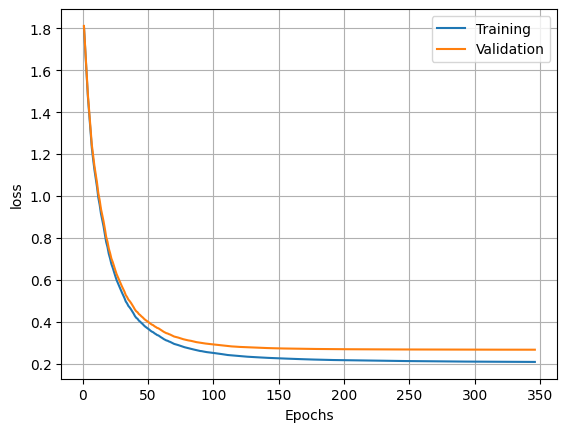

In [37]:
results = clfs[0].evals_result()

train_loss = results['validation_0']['mlogloss']
validation_loss = results['validation_1']['mlogloss']
epochs_grid = np.arange(1, len(train_loss)+1)

plt.plot(epochs_grid, train_loss, label='Training')
plt.plot(epochs_grid, validation_loss, label='Validation')
plt.legend()
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()

Explore results of one of the model previously trained

## 8. Try to improve accuracy using cross validation(혹시나 스태킹이 아닌 보팅을 사용할 경우 이거 사용! / 보팅 알고리즘으로 lgbm, xgb, gb 사용)
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:

- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [38]:
from sklearn.ensemble import VotingClassifier

clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
clf_xgb = XGBClassifier(**best_params_XGB)
clf_gb = GradientBoostingClassifier()
voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb)], 
                              voting='soft')

voting_clf.fit(X, y)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(colsample_bytree=0.6887969053502656,
                                             gamma=0.22192354930290237,
                                             learning_rate=0.009281736307668285,
                                             max_depth=6, min_child_weight=4,
                                             n_estimators=1959,
                                             reg_alpha=0.5825318169558447,
                                             reg_lambda=0.4799149236925663,
                                             subsample=0.015476748135703627,
                                             verbose=-1, verbosity=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None...
                                            interaction_constraints=None,
                                            learning_rate=0.07506053282243882,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1117, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [39]:
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = voting_clf.predict(X_test)
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)

print(df_submission)

df_submission.to_csv('submission_Voting(lgbm_xgb_gb).csv')

                NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]
